<a href="https://colab.research.google.com/github/argenis-gomez/B-W-to-Color-Images/blob/master/B%26W_to_Color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# B&W to Color

En este notebook utilizaremos una arquitectura Pix2Pix para dar color a imágenes en blanco y negro.

## Clonamos repositorio

En el repositorio tenemos el dataset que utilizaremos para entrenar el modelo.

In [1]:
!git clone https://github.com/argenis-gomez/B-W-to-Color-Images.git

fatal: destination path 'B-W-to-Color-Images' already exists and is not an empty directory.


## Importamos librerías

In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import *
import time
import math
from IPython import display

## Definimos las rutas

Tendremos:


1.   **INPATH**: Ruta donde están las imágenes en blanco y negro.
2.   **TARPATH**: Ruta donde están las imágenes a color.
3.   **CHECKPATH**: Ruta donde guardaremos los checkpoints del entrenamiento en caso que se interrumpa durante el mismo.



In [3]:
PATH = "./B-W-to-Color-Images"
INPATH = os.path.join(PATH,  "dataset", "bn/")
TARPATH = os.path.join(PATH, "dataset", "color/")
CHECKPATH = "./drive/My Drive/Color a imagenes en blanco y negro/checkpoints/"

In [4]:
print(f"Ruta de entrada:    {INPATH}")
print(f"Ruta objetivo:      {TARPATH}")
print(f"Ruta de checkpoint: {CHECKPATH}")

Ruta de entrada:    ./B-W-to-Color-Images/dataset/bn/
Ruta objetivo:      ./B-W-to-Color-Images/dataset/color/
Ruta de checkpoint: ./drive/My Drive/Color a imagenes en blanco y negro/checkpoints/


## Variables globales

In [5]:
N_IMG = 6000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

## Funciones de utlidad

In [6]:
def update(i, total):
  """Esta función sirve para mostrar el progeso del entrenamiento"""
  
  i += 1
  print("\r[{}{}] {}/{}".format("="*int(20*i/total), "-"*(20-int(20*i/total)), i, total), end="")
  time.sleep(0.1)

In [7]:
def resize(inimg, tgimg, height, weight):
  """Reescalamos la imágenes a IMG_WIDTH x IMG_HEIGHT"""
  
  inimg = tf.image.resize(inimg, (height, weight))
  tgimg = tf.image.resize(tgimg, (height, weight))

  return inimg, tgimg

In [8]:
def normalize(inimg, tgimg):
  """Normalizamos las imágenes entres -1 y 1"""
  
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg

In [9]:
def random_crop(inimg, tgimg):
  """Realizamos un movimiento aleatoreo a las imágenes, para que sean diferentes"""
  
  stacked_image = tf.stack([inimg, tgimg], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [10]:
@tf.function()
def random_jitter(inimg, tgimg):
  """Reescalamos, agregamos movimiento aleatoreo.
  Luego hacemos un flip aleatoreo"""
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT+30, IMG_WIDTH+30)

  inimg, tgimg = random_crop(inimg, tgimg)

  if tf.random.uniform(()) > 0.5:
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg

In [11]:
def load_image(file_name, augmentation=True):
  """Cargamos las imágenes"""

  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + file_name), 3), tf.float32)
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(TARPATH + file_name), 3), tf.float32)

  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)

  if augmentation:
    inimg, tgimg = random_jitter(inimg, tgimg)
    
  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg

def load_train(file_name):
  return load_image(file_name)

def load_test(file_name):
  return load_image(file_name, False)

In [12]:
def show_predicted(model, input, target, generator=True):
  """Mostramos la comparación de la imágen de entrada, la imágen esperada y la imágen predecida"""

  if generator:
    prediction = model(input)
  else:
    prediction = model(input, target)

  fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15,4))
  ax0.imshow((input[0,...]+1)/2)
  ax0.axis(False)
  ax0.set_title("Imagen de entrada")
  ax1.imshow((target[0,...]+1)/2)
  ax1.axis(False)
  ax1.set_title("Imagen objetivo")
  ax2.imshow((prediction[0,...]+1)/2)
  ax2.axis(False)
  ax2.set_title("Imagen predecida")

  plt.show()

## Imágen del dataset

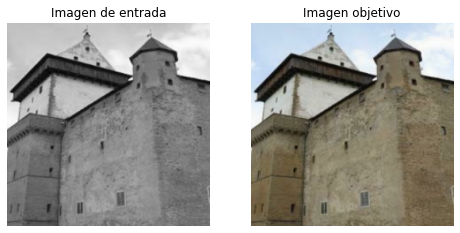

In [13]:
bn, color = load_image("img_000000.jpg")

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8,5))
ax0.imshow((bn+1)/2)
ax0.axis(False)
ax0.set_title("Imagen de entrada")
ax1.imshow((color+1)/2)
ax1.axis(False)
ax1.set_title("Imagen objetivo")

plt.show()

## Preparación de los datos

Dependiendo del *N_IMG* seleccionaremos el 80% para entrenar y 20% para validación

In [14]:
train_n = round(N_IMG * 0.8)

imgurls = os.listdir(INPATH)
randurls = np.copy(imgurls)
np.random.shuffle(randurls)

train_urls = randurls[:train_n]
test_urls  = randurls[train_n:N_IMG]

print(f"Total de imagenes de entrada: {len(imgurls)}.")
print(f"Imagenes de entrenamiento: {len(train_urls)}.")
print(f"Imagenes de prueba: {len(test_urls)}.")

Total de imagenes de entrada: 6720.
Imagenes de entrenamiento: 4800.
Imagenes de prueba: 1200.


Creamos los Tensores para entrenar y validar el modelo

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_urls)
train_dataset = train_dataset.map(load_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_IMG).batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_urls)
test_dataset = test_dataset.map(load_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(N_IMG).batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

Mostramos algunos ejemplos de los tensores de entrenamiento.

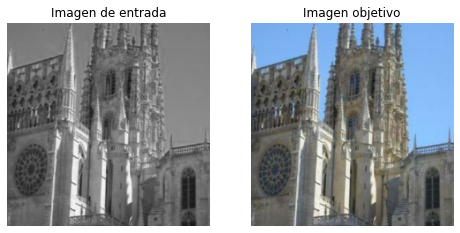

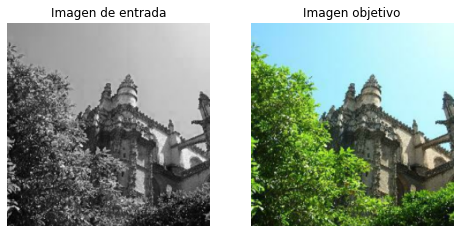

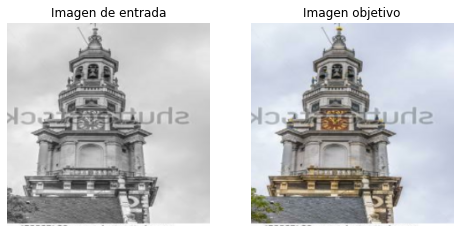

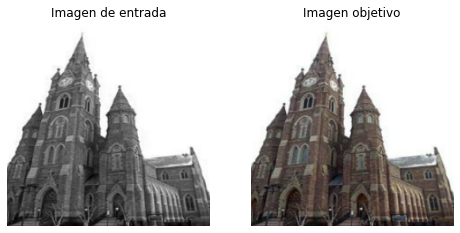

In [16]:
for input, target in train_dataset.take(4):
  fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8,5))
  ax0.imshow((input[0,...]+1)/2)
  ax0.axis(False)
  ax0.set_title("Imagen de entrada")
  ax1.imshow((target[0,...]+1)/2)
  ax1.axis(False)
  ax1.set_title("Imagen objetivo")

  plt.show()

## Modelo Pix2Pix

Definimos dos funciones:


1.   downsample.
2.   upsample.

Estas nos servirán para definir nuestro Generador y nuestro Discriminador.



In [17]:
def downsample(filters, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(layers.Conv2D(filters,
                           kernel_size=4,
                           strides=2,
                           padding='same',
                           kernel_initializer=initializer,
                           use_bias=False))

  if apply_batchnorm:
    result.add(layers.BatchNormalization())

  result.add(layers.LeakyReLU())

  return result

In [18]:
def upsample(filters, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(layers.Conv2DTranspose(filters,
                                    kernel_size=4,
                                    strides=2,
                                    padding='same',
                                    kernel_initializer=initializer))

  result.add(layers.BatchNormalization())

  if apply_dropout:
      result.add(layers.Dropout(0.5))

  result.add(layers.ReLU())

  return result

### Generador

In [19]:
def Generator():
  inputs = layers.Input(shape=[None,None,3])

  down_stack = [
    downsample(64, apply_batchnorm=False),
    downsample(128),
    downsample(256),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512),
    downsample(512)
  ]

  up_stack = [
    upsample(512, apply_dropout=True),
    upsample(512, apply_dropout=True),
    upsample(512, apply_dropout=True),
    upsample(512),
    upsample(256),
    upsample(128),
    upsample(64),
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = layers.Conv2DTranspose(3,
                                kernel_size=4,
                                strides=2,
                                padding='same',
                                kernel_initializer=initializer,
                                activation='tanh') # (bs, 128, 128, 3)

  x = inputs

  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = layers.Concatenate()([x, skip])

  x = last(x)

  return Model(inputs=inputs, outputs=x)

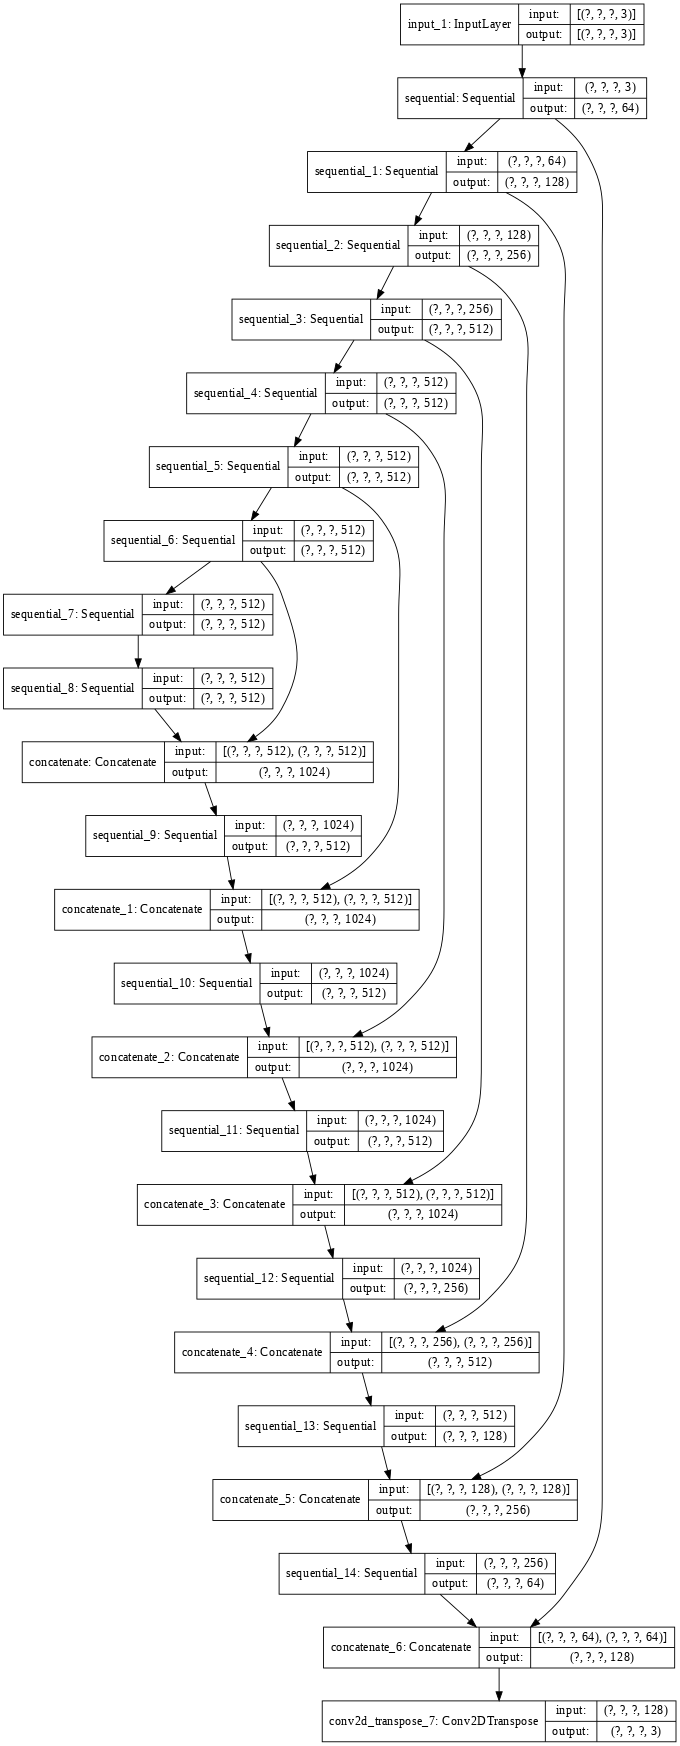

In [20]:
generator = Generator()
utils.plot_model(generator, show_shapes=True, dpi=64)

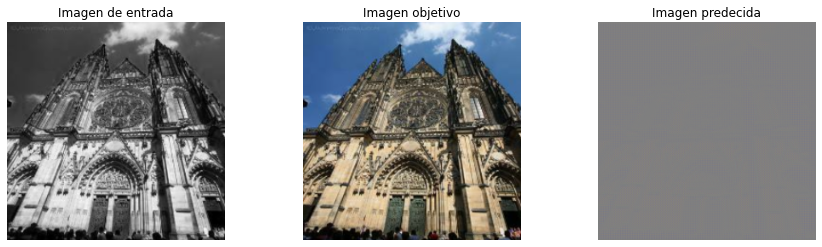

In [21]:
for input, target in train_dataset.take(1):
  show_predicted(generator, input, target)

Observamos que el modelo solo predice ruido ya que no está entrenado.

### Discriminador

In [22]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = layers.Input(shape=[None, None, 3], name='input_image')
  tar = layers.Input(shape=[None, None, 3], name='target_image')

  x = layers.concatenate([inp, tar])

  down1 = downsample(64, False)(x)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)

  zero_pad1 = layers.ZeroPadding2D()(down3)
  conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

  batchnorm1 = layers.BatchNormalization()(conv)

  leaky_relu = layers.LeakyReLU()(batchnorm1)

  zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

  last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

  return Model(inputs=[inp, tar], outputs=last)

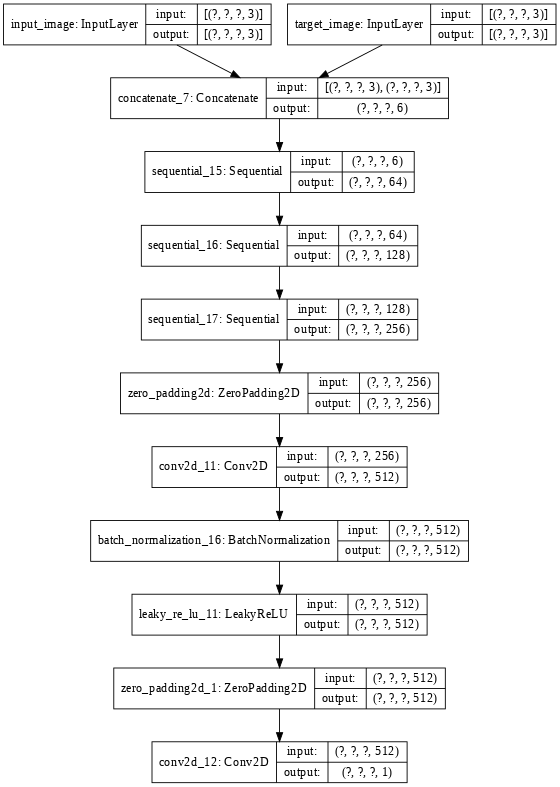

In [23]:
discriminator = Discriminator()
utils.plot_model(discriminator, show_shapes=True, dpi=64)

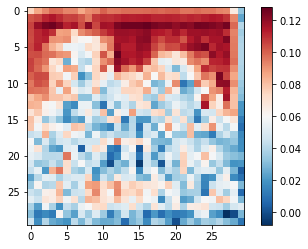

In [24]:
for input, target in test_dataset.take(1):
  gen_out = generator(input)
  disct_out = discriminator([gen_out, input])
  plt.imshow(disct_out[0,...,-1], cmap="RdBu_r")
  plt.colorbar()

### Funciones de perdida

In [25]:
LAMBDA = 100
loss_object = losses.BinaryCrossentropy(from_logits=True)

In [26]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [27]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Funciones de optimización

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Definimos el checkpoint

Creamos el *checkpoint* y verificamos que haya alguno existente. En caso de que exista lo restauramos, en caso contrario lo inicializamos desde cero.

In [29]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

if os.path.isdir(CHECKPATH):
  checkpoint.restore(tf.train.latest_checkpoint(CHECKPATH))

else:
  os.mkdir(CHECKPATH)

checkpoint_prefix = os.path.join(CHECKPATH, "ckpt")

## Entrenamiento

In [30]:
@tf.function
def train_step(input_image, target, epoch):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [31]:
def fit(train_ds, epochs, test_ds, show=1):
  total = math.ceil(train_n / BATCH_SIZE)

  for epoch in range(epochs):
    display.clear_output(wait=True)

    start = time.time()

    for example_input, example_target in test_ds.take(show):
      show_predicted(generator, example_input, example_target)

    print(f"Epoch: {epoch+1}/{epochs}")

    for n, (input_image, target) in train_ds.enumerate():
      update(n, total)
      train_step(input_image, target, epoch)

    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print (f"\nTime taken for epoch {epoch + 1} is {(time.time()-start)/60:2.2f} min")
    
  checkpoint.save(file_prefix = checkpoint_prefix)

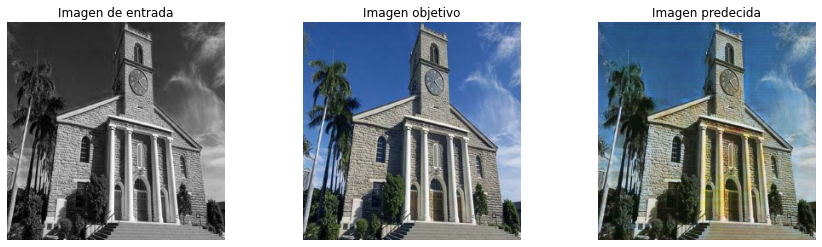

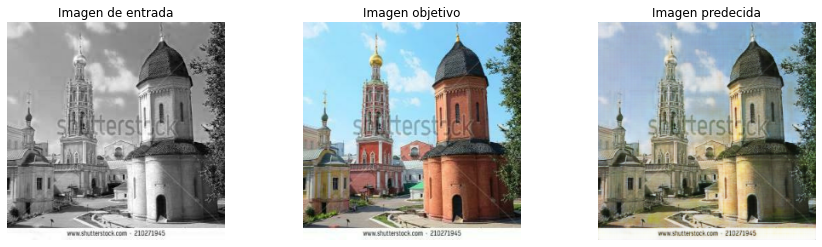

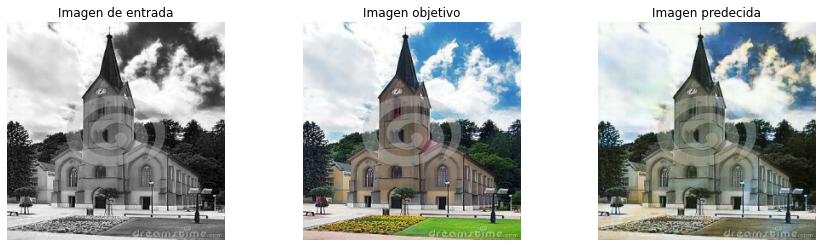

Epoch: 10/10
[====================] 4800/4800
Time taken for epoch 10 is 12.56 min


In [32]:
EPOCHS = 10
fit(train_dataset, EPOCHS, test_dataset, show=3)

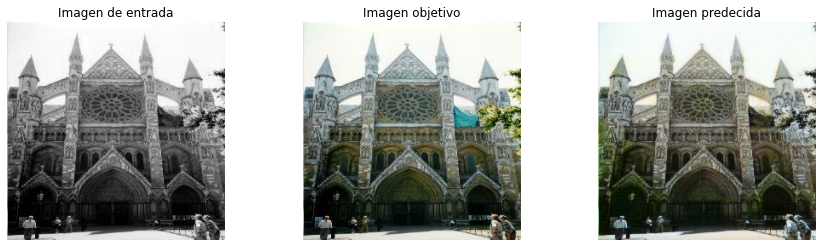

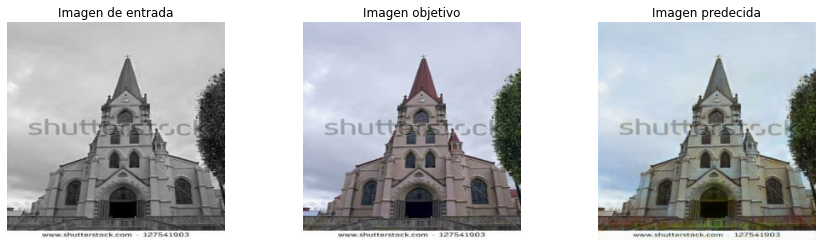

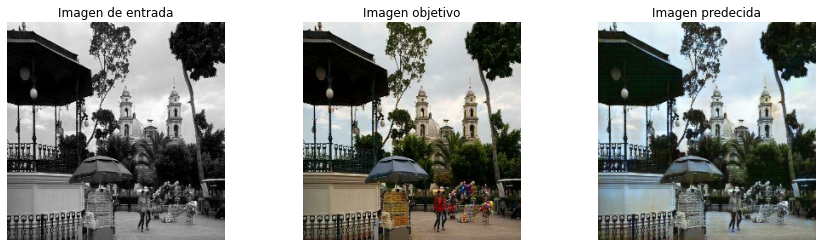

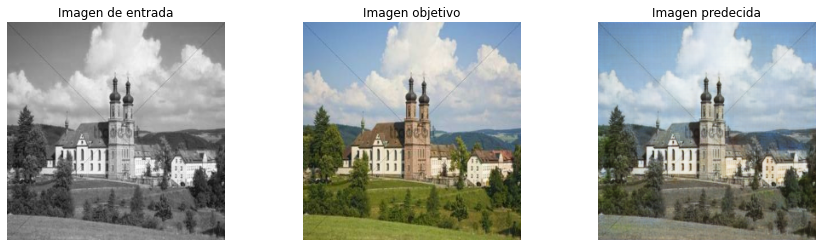

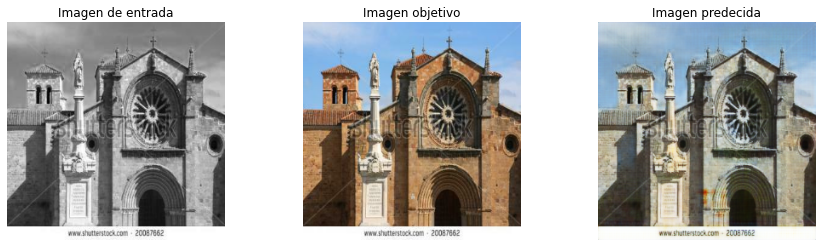

In [33]:
for example_input, example_target in test_dataset.take(5):
      show_predicted(generator, example_input, example_target)